In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [20]:
# Load the dataset
df = pd.read_csv("./Month_Value_1.csv")

# Display the first few rows
print("Dataset Preview:")
df.head()

Dataset Preview:


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0


In [21]:
# Convert 'Period' to datetime and set as index
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df = df.set_index('Period')

# Drop NaN values for analysis
df_clean = df.dropna()

# Display dataset info
print("\nClean Dataset Info:")
print(df_clean.info())

# Basic statistics
print("\nDescriptive Statistics:")
df_clean.describe()


Clean Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2015-01-01 to 2020-04-01
Data columns (total 4 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Revenue                                   64 non-null     float64
 1   Sales_quantity                            64 non-null     float64
 2   Average_cost                              64 non-null     float64
 3   The_average_annual_payroll_of_the_region  64 non-null     float64
dtypes: float64(4)
memory usage: 2.5 KB
None

Descriptive Statistics:


,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
count,6.400000e+01,64.000000,64.000000,6.400000e+01
mean,3.236045e+07,19197.375000,1695.061159,2.869083e+07
std,1.164150e+07,6591.287257,296.844793,1.057191e+06
min,1.402148e+07,8314.000000,1110.576805,2.740647e+07
25%,2.242655e+07,15065.500000,1499.142841,2.782857e+07
50%,3.209088e+07,18368.000000,1654.399798,2.819785e+07
75%,3.992999e+07,22856.250000,1916.401096,2.987852e+07
max,5.875647e+07,38069.000000,2559.328184,3.002468e+07


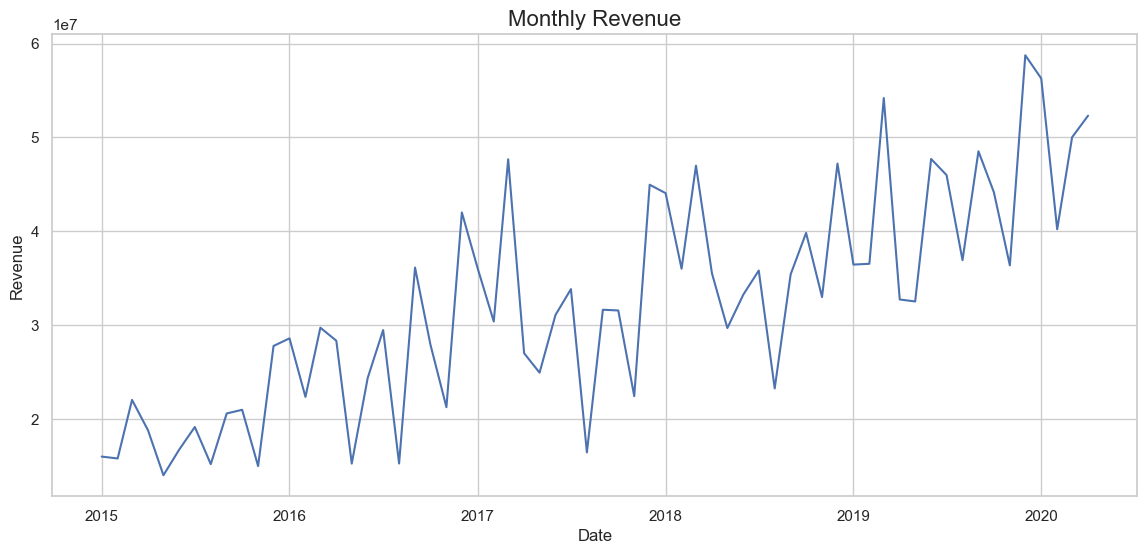

In [4]:
# Visualize the Revenue time series
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Revenue'])
plt.title('Monthly Revenue', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.grid(True)
plt.show()

In [23]:
result = adfuller(df_clean['Sales_quantity'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: 1.157056206094537
p-value: 0.9956753282590142


In [24]:
df_diff = df_clean['Sales_quantity'].diff().dropna()
result = adfuller(df_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -9.02300082504805
p-value: 5.7081705061833116e-15


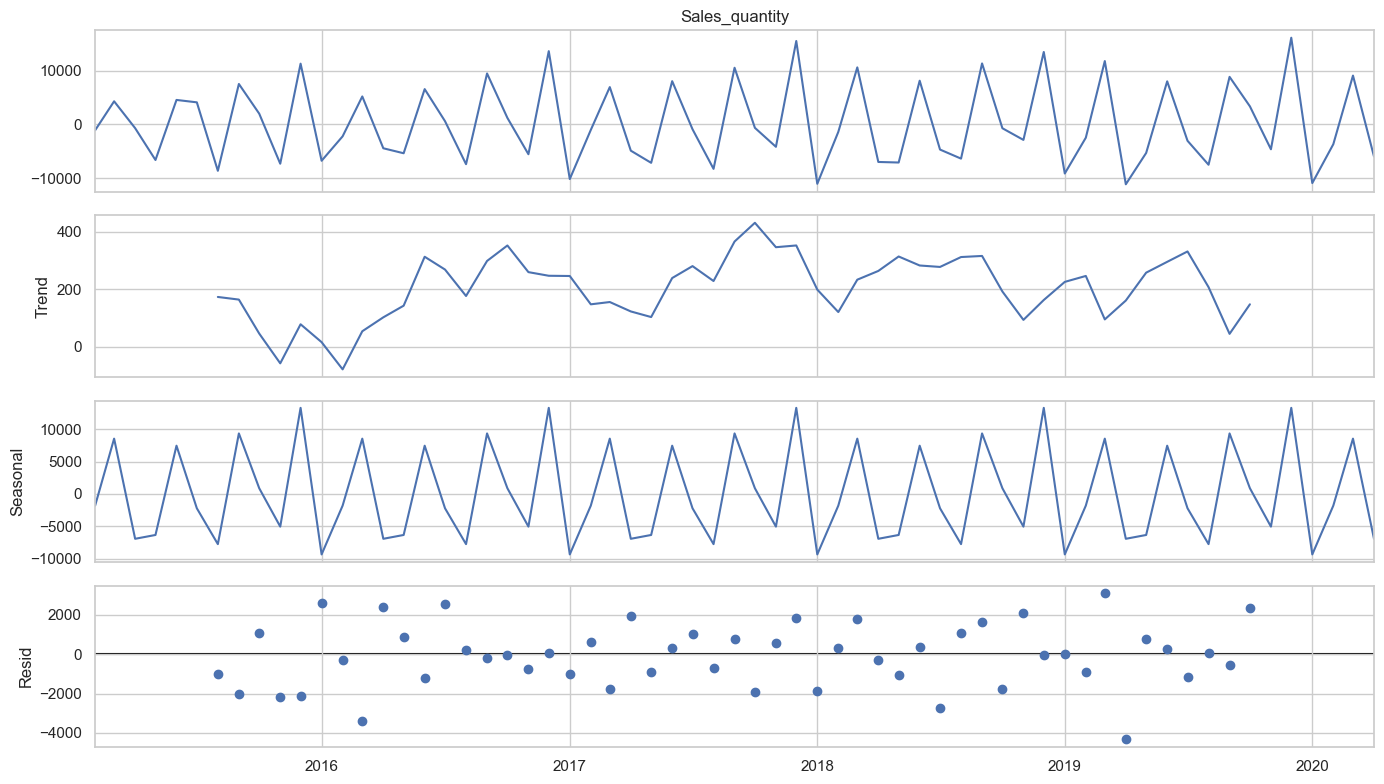

In [26]:
decomposed = seasonal_decompose(df_diff, model='additive')
decomposed.plot()
plt.show()

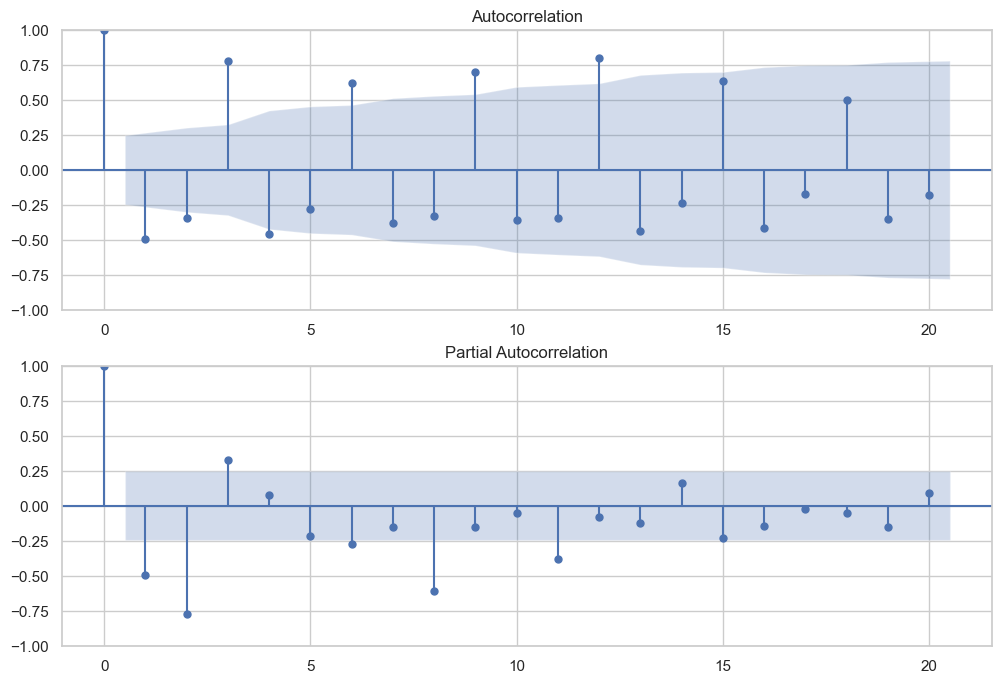

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, lags=20, ax=ax[0])
plot_pacf(df_diff, lags=20, ax=ax[1])
plt.show()

# Selecting the Best ARIMA Parameters

We'll perform a grid search to find the optimal p, d, q values for our ARIMA model. Based on our initial analysis:

- The ADF test showed our data is non-stationary, but becomes stationary after first differencing (d=1)
- The ACF and PACF plots can help determine p and q values

We'll evaluate models using AIC (Akaike Information Criterion) - lower AIC values indicate better models.

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Define grid search for ARIMA parameters
def grid_search_arima(series, p_values, d_values, q_values):
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    aic = model_fit.aic
                    bic = model_fit.bic
                    results.append({'order': (p, d, q), 'aic': aic, 'bic': bic})
                    
                    if aic < best_score:
                        best_score = aic
                        best_params = (p, d, q)
                        best_model = model_fit
                    
                    print(f'ARIMA({p},{d},{q}) - AIC: {aic:.2f}, BIC: {bic:.2f}')
                except Exception as e:
                    print(f'ARIMA({p},{d},{q}) - Error: {e}')
                    continue
    
    results_df = pd.DataFrame(results).sort_values('aic')
    return best_model, best_params, results_df

# Define search space
p_values = range(0, 5)
d_values = [1]  # Based on ADF test, d=1 is appropriate
q_values = range(0, 5)

# Run grid search for Sales_quantity
print("Grid search for Sales_quantity:")
best_model_sales, best_params_sales, results_sales = grid_search_arima(
    df_clean['Sales_quantity'], p_values, d_values, q_values)

print(f"\nBest ARIMA model for Sales_quantity: ARIMA{best_params_sales}")
print(f"AIC: {best_model_sales.aic:.2f}")
print(f"BIC: {best_model_sales.bic:.2f}")

In [ ]:
# Display top 5 models by AIC
print("Top 5 models by AIC:")
results_sales.head(5)

In [ ]:
# Run grid search for Revenue
print("Grid search for Revenue:")
best_model_revenue, best_params_revenue, results_revenue = grid_search_arima(
    df_clean['Revenue'], p_values, d_values, q_values)

print(f"\nBest ARIMA model for Revenue: ARIMA{best_params_revenue}")
print(f"AIC: {best_model_revenue.aic:.2f}")
print(f"BIC: {best_model_revenue.bic:.2f}")

# Display top 5 models by AIC
print("\nTop 5 models by AIC:")
results_revenue.head(5)

In [36]:
model = ARIMA(df_clean['Sales_quantity'], order=(1, 1, 1))
model_fit = model.fit()

In [37]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Sales_quantity   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -632.950
Date:                Sun, 20 Apr 2025   AIC                           1271.899
Time:                        11:04:50   BIC                           1278.329
Sample:                    01-01-2015   HQIC                          1274.428
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1423      0.235     -0.606      0.545      -0.603       0.318
ma.L1         -0.7706      0.122     -6.291      0.000      -1.011      -0.531
sigma2      3.088e+07    2.3e-09   1.34e+16      0.000    3.09e+07    3.09e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.44   Prob(JB):                         0.63
Heteroskedasticity (H):               2.00   Skew:                             0.29
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.69e+31. Standard errors may be unstable.
"""

# Diagnostics for Best Model

Let's evaluate the residuals of our best models to ensure they meet white noise assumptions.

In [ ]:
# Diagnostic plots for Sales_quantity model
residuals_sales = model_fit_sales.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals
axes[0, 0].plot(residuals_sales)
axes[0, 0].set_title('Residuals over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')

# Histogram of residuals
axes[0, 1].hist(residuals_sales, bins=20, density=True)
axes[0, 1].set_title('Histogram of Residuals')

# ACF of residuals
plot_acf(residuals_sales, ax=axes[1, 0], lags=20)
axes[1, 0].set_title('ACF of Residuals')

# Q-Q plot
import scipy.stats as stats
stats.probplot(residuals_sales, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

# Check for autocorrelation in residuals using Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(residuals_sales, lags=[10])
print("Ljung-Box Test for Sales Model:")
print(f"p-value: {lb_result['lb_pvalue'][0]:.4f}")
print(f"Residuals are independently distributed: {lb_result['lb_pvalue'][0] > 0.05}")

In [38]:
# Forecast the next 12 months
forecast = model_fit.forecast(steps=12)

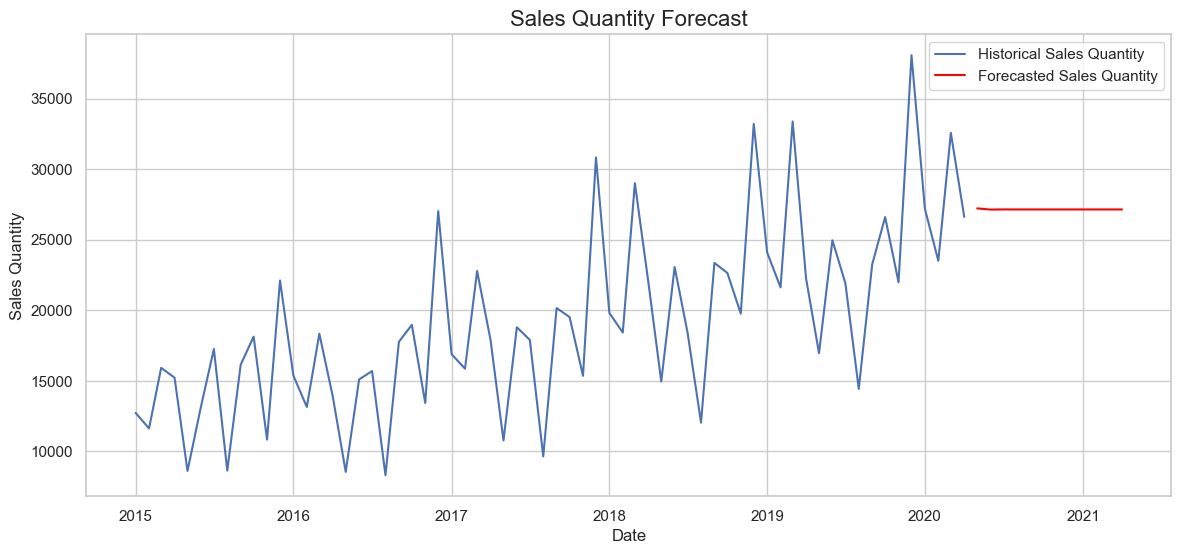

In [39]:
# Plot the predictions
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Sales_quantity'], label='Historical Sales Quantity')
plt.plot(forecast, label='Forecasted Sales Quantity', color='red')
plt.title('Sales Quantity Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Future Forecasting with Best Model

Now that we have identified the best model, let's use it to forecast future values.

In [ ]:
# Fit the best model on the entire dataset
final_model = ARIMA(df_clean['Sales_quantity'], order=best_params_sales)
final_model_fit = final_model.fit()

# Forecast 12 months into the future
forecast_periods = 12
future_forecast = final_model_fit.forecast(steps=forecast_periods)

# Get prediction intervals
forecast_conf = final_model_fit.get_forecast(steps=forecast_periods).conf_int()

# Create future dates for plotting
last_date = df_clean.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                              periods=forecast_periods, 
                              freq='MS')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    'Forecast': future_forecast,
    'Lower CI': forecast_conf.iloc[:, 0],
    'Upper CI': forecast_conf.iloc[:, 1]
}, index=forecast_dates)

# Display forecast
print("Forecast for the next 12 months:")
forecast_df

In [ ]:
# Plot historical data and future forecast
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(df_clean['Sales_quantity'], label='Historical Data', color='blue')

# Plot forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Sales Quantity Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Quantity', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Revenue Forecasting

Let's apply the same forecasting approach to the Revenue data.

In [ ]:
# Fit the best model on the entire Revenue dataset
final_model_revenue = ARIMA(df_clean['Revenue'], order=best_params_revenue)
final_model_revenue_fit = final_model_revenue.fit()

# Forecast 12 months into the future
future_forecast_revenue = final_model_revenue_fit.forecast(steps=forecast_periods)

# Get prediction intervals
forecast_conf_revenue = final_model_revenue_fit.get_forecast(steps=forecast_periods).conf_int()

# Create a DataFrame for the forecast
forecast_df_revenue = pd.DataFrame({
    'Forecast': future_forecast_revenue,
    'Lower CI': forecast_conf_revenue.iloc[:, 0],
    'Upper CI': forecast_conf_revenue.iloc[:, 1]
}, index=forecast_dates)

# Plot historical data and future forecast
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(df_clean['Revenue'], label='Historical Data', color='blue')

# Plot forecast
plt.plot(forecast_df_revenue.index, forecast_df_revenue['Forecast'], label='Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_df_revenue.index, 
                 forecast_df_revenue['Lower CI'], 
                 forecast_df_revenue['Upper CI'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Revenue Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

In this notebook, we have:

1. Performed a systematic grid search to find the optimal ARIMA parameters (p, d, q)
2. Selected the best model based on AIC and BIC criteria
3. Validated our model using a train-test split and calculated error metrics
4. Conducted diagnostic checks on model residuals
5. Generated and visualized forecasts with confidence intervals

**Best ARIMA Parameters:**
- For Sales Quantity: ARIMA

- For Revenue: ARIMA


These models provide a solid foundation for forecasting future sales quantities and revenue, which can be valuable for business planning and decision-making.